In [1]:
import json
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors
import random
import torch
import os
import logging
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
from utils.util import write_json, load_json

In [54]:
def AVG(data, avg_freq):
    result = []
    for i in range((len(data) + avg_freq - 1) // avg_freq):
        sublist = data[i*avg_freq:(i+1)*avg_freq]
        result.append(sum(sublist) / len(sublist))
    return result

In [55]:
def plot_loss(train_loss, avg_freq):
    """
        Plot Loss Function to check the convergence issue. 
        Especially the discriminator-generator update ratio
    """
    nrows = 2
    ncols = 2
    
    losses = {}
    names = ['dis_cls', 'gen_cls', 'gen_lm', 'gen_adv']
    # preprocess the loss in average:
    for i in range(len(names)):
        losses[names[i]] = AVG(train_loss[i], avg_freq)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            if i == 0 and j == 0:
                z = 0
                ax.plot(losses[names[z]], color='blue')
                ax.set_ylim(0, 4)
                ax.set_title(f'Discriminator: CLS Loss')
            elif i == 0 and j == 1:
                z = 1
                ax.plot(losses[names[z]], color='blue')
                ax.set_ylim(0, 4)
                ax.set_title(f'Generator: CLS Loss')
            elif i == 1 and j == 0:
                z = 2
                ax.plot(losses[names[z]], color='blue')
                ax.set_ylim(2, 8)
                ax.set_title(f'Generator: LM Loss')
            elif i == 1 and j == 1:
                z = 3
                ax.plot(losses[names[z]], color='blue')
                ax.set_ylim(-15, 10)
                ax.set_title(f'Generator: Adv Loss')

    fig.suptitle('Training Loss')
    fig.tight_layout()
    plt.show()

In [9]:
def plot_alpha_and_sample_size(loss1, loss2, avg_freq, save_name, model_name):    
    nrows = 2
    ncols = 2
    names = ['dis_cls', 'gen_cls', 'gen_lm', 'gen_adv']
    losses_1 = {}
    losses_2 = {}
    
    # Column 1:
    # sample_size = 50000
    # Lm Loss 
    # Adv Los

    if save_name == 'training_loss_gpt2.pdf':
        sample_size_1 = 50000
        alphas_1 = [1,3,10]
        sample_size_2 = [10000, 20000, 50000]
        alphas_2 = 3
    else:
        sample_size_1 = 50000
        alphas_1 = [1,10]
        sample_size_2 = [10000, 20000, 50000]
        alphas_2 = 10
    # preprocess the loss in average:
    for j in range(len(loss1)):
        for i in range(len(names)):
            if names[i] == 'gen_lm' or names[i] == 'gen_adv':
                losses_1['Type_%s, Sample_%d, Alpha_%s' % (names[i], sample_size_1, str(alphas_1[j]))] = AVG(loss1['alpha_%d' % alphas_1[j]][i], avg_freq)
    
    # Column2:
    # alpha = 3
    # sample_size [10000, 20000, 50000]
    # Lm Loss
    # Adv Loss

    for j in range(len(loss2)):
        for i in range(len(names)):
            if names[i] == 'gen_lm' or names[i] == 'gen_adv':
                losses_2['Type_%s, Sample_%d, Alpha_%s' % (names[i], sample_size_2[j], str(alphas_2))] = AVG(loss2['sample_%d' % sample_size_2[j]][i], avg_freq)
    
    
    colors = ['c', 'm', 'y']
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    for j in range(ncols):
        for i in range(nrows):
            ax = axes[i][j]
            if i == 0 and j == 0:
                ax.set_ylim(2.75, 5)
                for z, alpha in enumerate(alphas_1):                    
                    x = np.arange(len(losses_1['Type_%s, Sample_%d, Alpha_%d' % ('gen_lm', sample_size_1, alpha)]))
                    ax.plot(x, losses_1['Type_%s, Sample_%d, Alpha_%d' % ('gen_lm', sample_size_1, alpha)], color=colors[z], label = 'alpha_%d'% (alpha))
                ax.set_title(f'Generator: LM Loss')
                ax.legend(loc = 'upper right')

            if i == 1 and j == 0:
                ax.set_ylim(-20, 10)
                for z, alpha in enumerate(alphas_1):
                    x = np.arange(len(losses_1['Type_%s, Sample_%d, Alpha_%d' % ('gen_adv', sample_size_1, alpha)]))
                    ax.plot(x, losses_1['Type_%s, Sample_%d, Alpha_%d' % ('gen_adv', sample_size_1, alpha)], color=colors[z], label = 'alpha_%d'% (alpha))
                ax.set_title(f'Generator: Total Loss')
                ax.legend(loc = 'upper right')
                
            if i == 0 and j == 1:
                ax.set_ylim(2.75, 5)
                for z, sample in enumerate(sample_size_2):                    
                    x = np.arange(len(losses_2['Type_%s, Sample_%d, Alpha_%d' % ('gen_lm', sample, alphas_2)]))
                    ax.plot(x, losses_2['Type_%s, Sample_%d, Alpha_%d' % ('gen_lm', sample, alphas_2)], color=colors[z], label = 'sample_%d'% (sample))
                ax.set_title(f'Generator: LM Loss')
                ax.legend(loc = 'upper right')
                
            if i == 1 and j == 1:
                ax.set_ylim(-20, 10)
                for z, sample in enumerate(sample_size_2):
                    x = np.arange(len(losses_2['Type_%s, Sample_%d, Alpha_%d' % ('gen_adv', sample, alphas_2)]))
                    ax.plot(x, losses_2['Type_%s, Sample_%d, Alpha_%d' % ('gen_adv', sample, alphas_2)], color=colors[z], label = 'sample_%d'% (sample))
                ax.set_title(f'Generator: Total Loss')
                ax.legend(loc = 'upper right')

    fig.suptitle('Training Loss: ' + model_name)
    fig.tight_layout()
    #plt.show()
    plt.savefig("../fig/%s" % (save_name))

In [71]:
def plot_metric(model_name, perplexity, gender, gender_std, age, age_std, race, race_std):
    random.seed(90025)
    n = len(model_name)
    nrows = 1
    ncols = 4
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(24, 6))
    all_color = sns.color_palette("pastel", n_colors=n)
    
    for j in range(ncols):
        ax = axes[j]
        if j == 0:
            ax.set_ylim(45, 60)
            x = np.arange(n)
            for ss, per in enumerate(perplexity):
                if ss== 1 or ss==2:
                    continue
                else:
                    ax.bar(ss, per, color=all_color[ss])
            for xx, yy in enumerate(perplexity):
                if xx== 1 or xx==2:
                    continue
                else:
                    ax.text(xx, yy, str(yy), color='blue', fontweight="bold")
            ax.set_title(f'Perplexity')
            ax.set_xticks(range(n))
            ax.set_xticklabels(model_name, rotation=90)
            
            
            ax.axhline(y=perplexity[0], color='green', linestyle='--')
            #ax.legend(loc = 'upper right')
        if j == 1:
            ax.set_ylim(0.01, 0.06)
            x = np.arange(n)
            ax.bar(x, gender, yerr=gender_std, color=all_color, \
                   align='center', ecolor='black', capsize=2)
            for xx, yy in enumerate(gender):      
                ax.text(xx, yy, str(yy), color='blue', fontweight="bold")
            ax.set_title(f'Gender RR')
            ax.set_xticks(range(n))
            ax.set_xticklabels(model_name, rotation=90)
            ax.axhline(y=gender[0], color='green', linestyle='--')
            #ax.legend(loc = 'upper right')
        if j == 2:
            ax.set_ylim(0.30, 0.48)
            x = np.arange(n)
            ax.bar(x, age, yerr=age_std, color=all_color, \
                   align='center', ecolor='black', capsize=2)
            for xx, yy in enumerate(age):
                ax.text(xx, yy, str(yy), color='blue', fontweight="bold")
            ax.set_title(f'Age RR')
            ax.set_xticks(range(n))
            ax.set_xticklabels(model_name, rotation=90)
            ax.axhline(y=age[0], color='green', linestyle='--')
            #ax.legend(loc = 'upper right')
        if j == 3:
            ax.set_ylim(0.62, 0.85)
            x = np.arange(n)
            ax.bar(x, race, yerr=race_std, color=all_color, \
                   align='center', ecolor='black', capsize=2)
            for xx, yy in enumerate(race):
                ax.text(xx, yy, str(yy), color='blue', fontweight="bold")
            ax.set_title(f'Race RR')
            ax.set_xticks(range(n))
            ax.set_xticklabels(model_name, rotation=90)
            ax.axhline(y=race[0], color='green', linestyle='--')
            #ax.legend(loc = 'upper right')

    fig.suptitle('Evaluation Metric', y=1)
    fig.tight_layout()
    #plt.show()
    plt.savefig("../fig/%s.pdf" % ('Evaluation Metric - 50K'))

# 1.1 Pretrained - GPT2 -  Alpha & Sample Size

In [10]:
model_type = "gpt2-aux"
epochs = 4
avg_freq = 20
load_type = ["Dis_CLS", "Gen_CLS", "Gen_lm", "Total_adv"]

# Loss 1 Preparation
sample_size = 50000
pretrain_or_not = "pretrain"
alpha = [1.0, 3.0, 10.0]
loss1 = {}

for z in range(len(alpha)):
    loss1['alpha_%d' % (alpha[z])] = []
    train_loss = [[] for i in range(4)]
    for j in range(4):
        for epoch in range(epochs):
            load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss.json" % \
                    (sample_size, model_type, pretrain_or_not, alpha[z], epoch, load_type[j])
            train_loss[j].extend(load_json(load_path))
    loss1['alpha_%d' % (alpha[z])] = train_loss
    
    
# Loss 2 Preparation
sample_size = [10000, 20000, 50000]
pretrain_or_not = "pretrain"
alpha = 3.0
loss2 = {}
for z in range(len(sample_size)):
    loss2['sample_%d' % (sample_size[z])] = []
    train_loss = [[] for i in range(4)]
    for j in range(4):
        for epoch in range(epochs):
            load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss.json" % \
                    (sample_size[z], model_type, pretrain_or_not, alpha, epoch, load_type[j])
            train_loss[j].extend(load_json(load_path))
    loss2['sample_%d' % (sample_size[z])] = train_loss

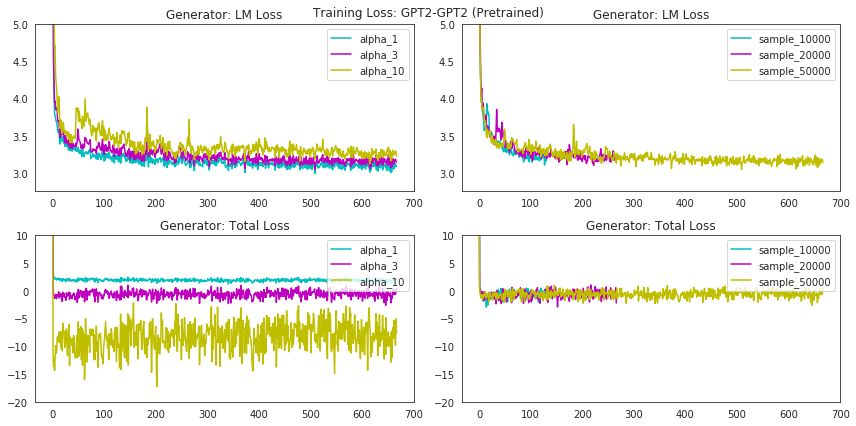

In [11]:
save_name = 'training_loss_gpt2.pdf'
model_name = 'GPT2-GPT2 (Pretrained)'
plot_alpha_and_sample_size(loss1, loss2, avg_freq, save_name, model_name)

# 1.2 Pretrained - RoBERTa - Alpha & Sample Size

In [12]:
model_type = "roberta-base-aux"
epochs = 4
avg_freq = 20
load_type = ["Dis_CLS", "Gen_CLS", "Gen_lm", "Total_adv"]

# Loss 1 Preparation
sample_size = 50000
pretrain_or_not = "pretrain"
alpha = [1.0, 10.0]
loss1 = {}

for z in range(len(alpha)):
    loss1['alpha_%d' % (alpha[z])] = []
    train_loss = [[] for i in range(4)]
    for j in range(4):
        for epoch in range(epochs):
            load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss.json" % \
                    (sample_size, model_type, pretrain_or_not, alpha[z], epoch, load_type[j])
            train_loss[j].extend(load_json(load_path))
    loss1['alpha_%d' % (alpha[z])] = train_loss
    
    
# Loss 2 Preparation
sample_size = [10000, 20000, 50000]
pretrain_or_not = "pretrain"
alpha = 10.0
loss2 = {}
for z in range(len(sample_size)):
    loss2['sample_%d' % (sample_size[z])] = []
    train_loss = [[] for i in range(4)]
    for j in range(4):
        for epoch in range(epochs):
            load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss.json" % \
                    (sample_size[z], model_type, pretrain_or_not, alpha, epoch, load_type[j])
            train_loss[j].extend(load_json(load_path))
    loss2['sample_%d' % (sample_size[z])] = train_loss

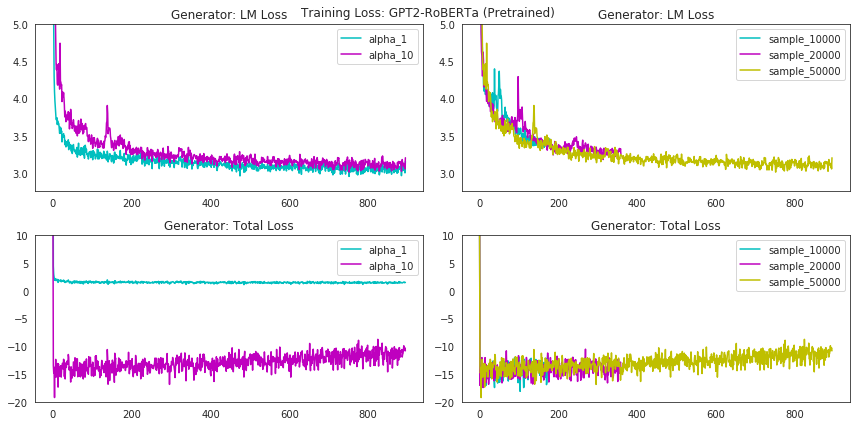

In [13]:
save_name = 'training_loss_roberta.pdf'
model_name = 'GPT2-RoBERTa (Pretrained)'
plot_alpha_and_sample_size(loss1, loss2, avg_freq, save_name, model_name)

# 2.1 Check Update the Discriminator update ratio affect - 40 - 20

In [ ]:
sample_size = 20000 # batch size = 12
model_type = "gpt2-aux"
pretrain_or_not = "pretrain"
alpha = 3.0
epochs = 4
avg_freq = 40
load_type = ["Dis_CLS", "Gen_CLS", "Gen_lm", "Total_adv"]
train_loss = [[] for i in range(4)]
for j in range(4):
    for epoch in range(epochs):
        load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss.json" % \
                (sample_size, model_type, pretrain_or_not, alpha, epoch, load_type[j])
        train_loss[j].extend(load_json(load_path))
        
plot_loss(train_loss, avg_freq)

# 2.2 Check Update the Discriminator update ratio affect - 80 - 20

In [ ]:
sample_size = 20000 # batch size = 12
model_type = "gpt2-aux"
pretrain_or_not = "pretrain"
alpha = 3.0
epochs = 4
avg_freq = 40
dis_freq = 80
gen_freq = 20
load_type = ["Dis_CLS", "Gen_CLS", "Gen_lm", "Total_adv"]
train_loss = [[] for i in range(4)]
for j in range(4):
    for epoch in range(epochs):
        load_path = "../loss_plot/sample_%d_model_%s_load_%s_alpha_%s_epoch_%d_%s_loss_D_%s_G_%s.json" % \
                (sample_size, model_type, pretrain_or_not, alpha, epoch, load_type[j], dis_freq, gen_freq)
        train_loss[j].extend(load_json(load_path))
        
plot_loss(train_loss, avg_freq)

# 3. Plot Fairness Metric Performance when sample size = 50000

In [209]:
model_meta_name = ['GPT2-GPT2', 'GPT2-RoBERTa']
model_type = ["(Init)", "(Pre)"]
alpha = [1,3,10]
model_name = []
for i in range(len(model_meta_name)):
    for j in range(len(model_type)):
        for z in range(len(alpha)):
            name = model_meta_name[i] + model_type[j] + "-A" + str(alpha[z])
            model_name.append(name)
model_name = [
 'GPT2',
 'Mask-1',
 'Mask-0.5',
 'GPT2(Init)-A1',
 'GPT2(Init)-A3',
 'GPT2(Init)-A10',
 'RoBERTa(Init)-A1',
 'RoBERTa(Init)-A10',
 'GPT2(Pre)-A1',
 'GPT2(Pre)-A3',
 'GPT2(Pre)-A10',
 'RoBERTa(Pre)-A1',
 'RoBERTa(Pre)-A10']

perplexity = [47.936, 132, 121, 49.518, 51.611, 51.554, 53.094, 58.373, 48.673, 52.766, 55.013, 54.079, 56.492]
gender = [0.058, 0.020, 0.021, 0.033, 0.038, 0.043, 0.050, 0.046, 0.031, 0.029, 0.046, 0.037, 0.039]
gender_std = [0.0040, 0.002, 0.003,0.002, 0.003, 0.001, 0.002, 0.004, 0.002, 0.002, 0.006, 0.003, 0.002]
age = [0.3874, 0.325, 0.370,0.356, 0.318, 0.362, 0.412, 0.339, 0.353, 0.324, 0.327, 0.437, 0.431]
age_std = [0.0055, 0.009, 0.008, 0.008, 0.008, 0.005, 0.008, 0.011, 0.004, 0.006, 0.007, 0.006, 0.012]
race = [0.6925, 0.664, 0.691, 0.814,0.661,0.663,0.720,0.711,0.728,0.675,0.648,0.734,0.727]
race_std = [0.008, 0.005, 0.007, 0.007, 0.003, 0.005, 0.008, 0.006, 0.009, 0.004, 0.003, 0.008, 0.006]

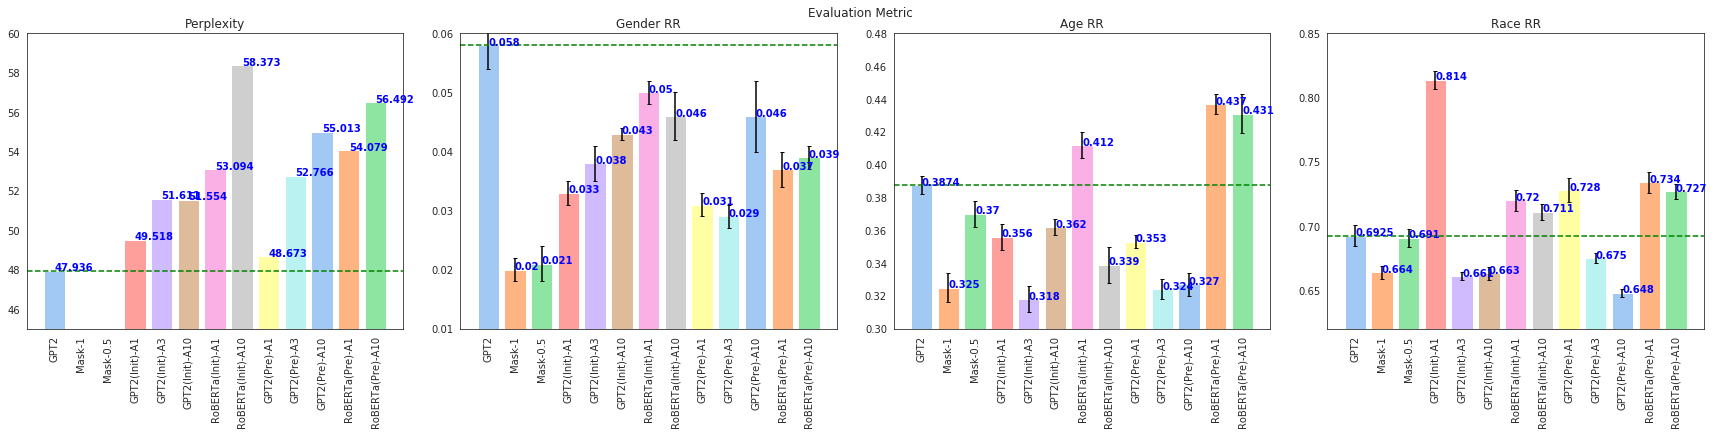

In [257]:
plot_metric(model_name, perplexity, gender, gender_std, age, age_std, race, race_std)